_____
Meridian Runtime Tutorial — "Getting Started"

Major changes in this revision:
- Modularized cells: smaller, single-purpose code blocks with clear execution order
- Stable rendering: consistent cell heights and widget panel sizes via metadata/layout
- Minimal, professional narrative: brief context before or after code cells
- Optional heavy sections: policy comparison and observability demo are collapsible and not auto-run
- Reproducibility: seeded randomness and lightweight sanity checks

How to run end-to-end:
1) Run the Environment & Imports cells
2) Run Meridian Runtime import checks
3) Run Graph Visualizer and Interactive Builder cells

4) Display the Interactive Experience (build → run → experiment → reset)

5) Optionally expand and run: Backpressure Policy Comparison, Observability Demo
---

# Getting Started with Meridian Runtime: Interactive Graph Building

Welcome to your first interactive Meridian Runtime tutorial! This notebook provides hands-on experience with building dataflow graphs, understanding execution models, and exploring backpressure mechanisms through professional visualizations and real-time monitoring.

## Learning Objectives

By the end of this tutorial, you'll understand:

- **Core Components**: Nodes, edges, subgraphs, and the scheduler
- **Graph Construction**: Building and connecting processing units
- **Execution Model**: How messages flow through bounded queues
- **Backpressure**: Flow control mechanisms and policies
- **Observability**: Real-time monitoring and visualization
- **Interactive Experimentation**: Parameter tuning and behavior analysis

## Prerequisites & Setup

Ensure you have the required dependencies installed:

**Recommended Setup (using `uv`):**
```bash
uv sync --extra notebooks
uv run python -c "import meridian, ipywidgets, matplotlib, networkx, pandas, plotly; print('✅ All dependencies ready')"
```

**Alternative Setup (using `pip`):**
```bash
python -m venv .venv && source .venv/bin/activate
pip install -e .
pip install -r notebooks/requirements.txt
python -c "import meridian, ipywidgets, matplotlib, networkx, pandas, plotly; print('✅ All dependencies ready')"
```

**Requirements:** Python 3.11+, ipywidgets 8.0+, matplotlib 3.7+, networkx 3.0+, pandas 2.0+, plotly 5.0+

In [1]:
# Environment verification and imports (stable height via cell metadata)
import sys
import platform
import time
import threading
from typing import Any, Dict, List, Tuple, Optional
from dataclasses import dataclass
from collections import deque
import uuid

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import networkx as nx
import pandas as pd
import numpy as np

# Reproducibility
np.random.seed(42)

# Configure matplotlib for better appearance
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = '#f8f9fa'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

print("🔧 Environment Information:")
print(f"   Python: {sys.version.split()[0]}")
print(f"   Platform: {platform.platform()}")

# Lightweight sanity check
assert hasattr(widgets, "VBox"), "ipywidgets not available"

# Verify all required packages
try:
    import meridian
    import ipywidgets
    import matplotlib
    import networkx
    import pandas
    import plotly
    
    print("\n📦 Package Versions:")
    print(f"   Meridian: {getattr(meridian, '__version__', 'dev')}")
    print(f"   ipywidgets: {ipywidgets.__version__}")
    print(f"   matplotlib: {matplotlib.__version__}")
    print(f"   networkx: {networkx.__version__}")
    print(f"   pandas: {pandas.__version__}")
    print(f"   plotly: {plotly.__version__}")
    print("\n✅ Environment verification complete!")
except ImportError as e:
    print(f"❌ Missing dependency: {e}")
    print("Please run the setup commands above.")

🔧 Environment Information:
   Python: 3.12.11
   Platform: macOS-15.6-arm64-arm-64bit

📦 Package Versions:
   Meridian: 0.0.0
   ipywidgets: 8.1.7
   matplotlib: 3.10.5
   networkx: 3.5
   pandas: 2.3.1
   plotly: 6.2.0

✅ Environment verification complete!


In [2]:
# Import Meridian Runtime components
from meridian.core import (
    Node, Message, MessageType, Subgraph, Scheduler, SchedulerConfig,
    PortSpec, Port, PortDirection
)
from meridian.observability.config import ObservabilityConfig, configure_observability
from meridian.observability.logging import get_logger, with_context
from meridian.core.policies import Block, Drop, Latest, Coalesce, PutResult

# Verify API compatibility
assert hasattr(Subgraph, "from_nodes"), "Unexpected Subgraph API; update notebook to match library"
assert hasattr(Scheduler, "register"), "Unexpected Scheduler API; update notebook to match library"

print("✅ Meridian Runtime imported successfully!")
print("📚 Ready to explore dataflow graphs!")

✅ Meridian Runtime imported successfully!
📚 Ready to explore dataflow graphs!


## Step 1: Understanding Core Components

Meridian Runtime core concepts:
1. Nodes: single-responsibility processing units
2. Edges: bounded queues connecting nodes
3. Subgraphs: composable node/edge collections
4. Scheduler: orchestrates execution and backpressure

We start with enhanced producer/consumer nodes and basic stats for visualization.

In [3]:
@dataclass
class NodeStats:
    """Statistics tracking for nodes"""
    messages_sent: int = 0
    messages_received: int = 0
    current_value: Optional[Any] = None
    is_complete: bool = False
    last_values: List[Any] = None
    all_values: List[Any] = None
    processing_times: List[float] = None
    
    def __post_init__(self):
        if self.last_values is None:
            self.last_values = []
        if self.all_values is None:
            self.all_values = []
        if self.processing_times is None:
            self.processing_times = []

class EnhancedProducer(Node):
    """A producer that generates numbers with comprehensive monitoring."""
    
    def __init__(self, name: str = "producer", max_count: int = 10, delay_ms: int = 0):
        super().__init__(
            name=name,
            inputs=[],
            outputs=[Port("output", PortDirection.OUTPUT, spec=PortSpec("output", int))]
        )
        self._max_count = max_count
        self._current = 0
        self._delay_ms = delay_ms
        self._stats = NodeStats()
        self._start_time = time.time()
        
    def _handle_tick(self):
        """Emit a number on each tick until we reach max_count."""
        if self._current < self._max_count:
            start_time = time.perf_counter()
            
            # Optional delay to simulate processing time
            if self._delay_ms > 0:
                time.sleep(self._delay_ms / 1000.0)
            
            # Emit the message
            msg = Message(MessageType.DATA, self._current)
            self.emit("output", msg)
            
            # Update statistics
            processing_time = time.perf_counter() - start_time
            self._stats.messages_sent += 1
            self._stats.current_value = self._current
            self._stats.processing_times.append(processing_time)
            self._stats.all_values.append(self._current)
            self._stats.is_complete = (self._current + 1) >= self._max_count
            
            self._current += 1
            
    def get_stats(self) -> NodeStats:
        """Get current statistics for visualization."""
        return self._stats
    
    def reset(self):
        """Reset the producer state."""
        self._current = 0
        self._stats = NodeStats()
        self._start_time = time.time()

class EnhancedConsumer(Node):
    """A consumer that collects and analyzes received messages."""
    
    def __init__(self, name: str = "consumer", delay_ms: int = 0):
        super().__init__(
            name=name,
            inputs=[Port("input", PortDirection.INPUT, spec=PortSpec("input", int))],
            outputs=[]
        )
        self._delay_ms = delay_ms
        self._stats = NodeStats()
        self._start_time = time.time()
        
    def _handle_message(self, port: str, msg: Message):
        """Process incoming messages with timing and statistics."""
        if port == "input":
            start_time = time.perf_counter()
            
            # Optional delay to simulate processing time
            if self._delay_ms > 0:
                time.sleep(self._delay_ms / 1000.0)
            
            # Update statistics
            processing_time = time.perf_counter() - start_time
            self._stats.messages_received += 1
            self._stats.current_value = msg.payload
            self._stats.all_values.append(msg.payload)
            self._stats.last_values = self._stats.all_values[-5:]  # Keep last 5
            self._stats.processing_times.append(processing_time)
            
            print(f"📨 {self.name} received: {msg.payload} (processed in {processing_time*1000:.2f}ms)")
            
    def get_stats(self) -> NodeStats:
        """Get current statistics for visualization."""
        return self._stats
    
    def reset(self):
        """Reset the consumer state."""
        self._stats = NodeStats()
        self._start_time = time.time()

print("✅ Enhanced Producer and Consumer nodes created!")

✅ Enhanced Producer and Consumer nodes created!


## Step 2: Professional Graph Visualization
A small helper that draws the graph topology and a performance dashboard sized for the layout.

In [4]:
class GraphVisualizer:
    """Professional graph visualization with interactive features."""
    
    def __init__(self):
        self.colors = {
            'node': '#2E86AB',
            'producer': '#A23B72', 
            'consumer': '#F18F01',
            'edge': '#C73E1D',
            'background': '#F5F5F5',
            'text': '#2C3E50'
        }
        
    def create_topology_plot(self, graph: Subgraph, title: str = "Graph Topology") -> go.Figure:
        """Create an interactive topology visualization using Plotly with proper sizing."""
        
        # Create NetworkX graph for layout
        G = nx.DiGraph()
        
        # Add nodes with metadata
        for node_name, node in graph.nodes.items():
            node_type = 'producer' if not node.inputs else 'consumer' if not node.outputs else 'processor'
            G.add_node(node_name, 
                      type=node_type,
                      inputs=len(node.inputs),
                      outputs=len(node.outputs))
        
        # Add edges with capacity information
        edge_info = []
        for edge in graph.edges:
            G.add_edge(edge.source_node, edge.target_node, 
                      capacity=edge.capacity,
                      source_port=edge.source_port.name,
                      target_port=edge.target_port.name)
            edge_info.append({
                'source': edge.source_node,
                'target': edge.target_node,
                'capacity': edge.capacity,
                'source_port': edge.source_port.name,
                'target_port': edge.target_port.name
            })
        
        # Calculate layout with better spacing
        pos = nx.spring_layout(G, k=5, iterations=100, seed=42)
        
        # Scale positions to use more space
        scale_factor = 2.0
        for node in pos:
            pos[node] = (pos[node][0] * scale_factor, pos[node][1] * scale_factor)
        
        # Create edge traces with arrows
        edge_traces = []
        for edge in edge_info:
            x0, y0 = pos[edge['source']]
            x1, y1 = pos[edge['target']]
            
            # Calculate arrow position (80% along the edge)
            arrow_x = x0 + 0.8 * (x1 - x0)
            arrow_y = y0 + 0.8 * (y1 - y0)
            
            # Main edge line
            edge_trace = go.Scatter(
                x=[x0, x1, None],
                y=[y0, y1, None],
                mode='lines',
                line=dict(width=4, color=self.colors['edge']),
                hoverinfo='text',
                hovertext=f"<b>{edge['source']}:{edge['source_port']}</b> → <b>{edge['target']}:{edge['target_port']}</b><br>Capacity: <b>{edge['capacity']}</b> messages<br>Click to see edge details",
                showlegend=False,
                name=f"Edge {edge['source']}→{edge['target']}"
            )
            edge_traces.append(edge_trace)
            
            # Arrow head
            arrow_trace = go.Scatter(
                x=[arrow_x],
                y=[arrow_y],
                mode='markers',
                marker=dict(
                    symbol='triangle-right',
                    size=15,
                    color=self.colors['edge'],
                    line=dict(width=1, color='white')
                ),
                hoverinfo='skip',
                showlegend=False
            )
            edge_traces.append(arrow_trace)
        
        # Create node trace with better sizing
        node_x, node_y, node_text, node_colors, node_sizes, hover_text = [], [], [], [], [], [], []
        
        for node_name in G.nodes():
            x, y = pos[node_name]
            node_x.append(x)
            node_y.append(y)
            
            node_data = G.nodes[node_name]
            node_text.append(node_name)
            
            # Enhanced hover text
            hover_info = f"<b>{node_name}</b><br>"
            hover_info += f"Type: <b>{node_data['type'].title()}</b><br>"
            hover_info += f"Input Ports: <b>{node_data['inputs']}</b><br>"
            hover_info += f"Output Ports: <b>{node_data['outputs']}</b><br>"
            hover_info += "Click to inspect node details"
            hover_text.append(hover_info)
            
            # Color and size by type
            if node_data['type'] == 'producer':
                node_colors.append(self.colors['producer'])
                node_sizes.append(40)
            elif node_data['type'] == 'consumer':
                node_colors.append(self.colors['consumer'])
                node_sizes.append(40)
            else:
                node_colors.append(self.colors['node'])
                node_sizes.append(35)
        
        node_trace = go.Scatter(
            x=node_x, y=node_y,
            mode='markers+text',
            marker=dict(
                size=node_sizes, 
                color=node_colors, 
                line=dict(width=3, color='white'),
                opacity=0.9
            ),
            text=node_text,
            textposition="middle center",
            textfont=dict(color='white', size=14, family='Arial Black'),
            hoverinfo='text',
            hovertext=hover_text,
            showlegend=False,
            name="Graph Nodes"
        )
        
        # Create figure with proper sizing
        fig = go.Figure(data=[*edge_traces, node_trace])
        
        fig.update_layout(
            title=dict(
                text=title, 
                x=0.5, 
                font=dict(size=18, color=self.colors['text'], family='Arial Black')
            ),
            showlegend=False,
            hovermode='closest',
            width=None,
            height=500,  # Fixed height for top-right panel
            margin=dict(b=40, l=40, r=40, t=60),
            annotations=[
                dict(
                    text="💡 Hover over nodes and edges for detailed information", 
                    showarrow=False, 
                    xref="paper", 
                    yref="paper",
                    x=0.5, 
                    y=-0.08, 
                    xanchor='center', 
                    yanchor='top',
                    font=dict(color=self.colors['text'], size=12, style='italic')
                )
            ],
            xaxis=dict(
                showgrid=False, 
                zeroline=False, 
                showticklabels=False,
                range=[-3, 3]
            ),
            yaxis=dict(
                showgrid=False, 
                zeroline=False, 
                showticklabels=False,
                range=[-2.5, 2.5]
            ),
            plot_bgcolor='#fafafa',
            paper_bgcolor='white',
            font=dict(family='Arial, sans-serif')
        )
        
        return fig
    
    def create_stats_dashboard(self, producer_stats: NodeStats, consumer_stats: NodeStats) -> go.Figure:
        """Create a comprehensive statistics dashboard with better sizing."""
        
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=(
                '📊 Message Flow Comparison', 
                '⏱️ Processing Times (ms)', 
                '📈 Cumulative Throughput', 
                '🔢 Message Values Received'
            ),
            specs=[[{"secondary_y": False}, {"secondary_y": False}],
                   [{"secondary_y": False}, {"secondary_y": False}]],
            vertical_spacing=0.12,
            horizontal_spacing=0.1
        )
        
        # Message flow comparison
        fig.add_trace(
            go.Bar(
                name='Messages Sent', 
                x=['Producer'], 
                y=[producer_stats.messages_sent], 
                marker_color=self.colors['producer'],
                text=[producer_stats.messages_sent],
                textposition='auto',
                hovertemplate='<b>Producer</b><br>Messages Sent: %{y}<extra></extra>'
            ),
            row=1, col=1
        )
        fig.add_trace(
            go.Bar(
                name='Messages Received', 
                x=['Consumer'], 
                y=[consumer_stats.messages_received],
                marker_color=self.colors['consumer'],
                text=[consumer_stats.messages_received],
                textposition='auto',
                hovertemplate='<b>Consumer</b><br>Messages Received: %{y}<extra></extra>'
            ),
            row=1, col=1
        )
        
        # Processing times
        if producer_stats.processing_times:
            processing_times_ms = [t * 1000 for t in producer_stats.processing_times]
            fig.add_trace(
                go.Scatter(
                    x=list(range(1, len(processing_times_ms) + 1)),
                    y=processing_times_ms, 
                    mode='lines+markers',
                    name='Producer Processing', 
                    line=dict(color=self.colors['producer'], width=3),
                    marker=dict(size=6),
                    hovertemplate='<b>Producer</b><br>Message: %{x}<br>Time: %{y:.2f}ms<extra></extra>'
                ),
                row=1, col=2
            )
        if consumer_stats.processing_times:
            processing_times_ms = [t * 1000 for t in consumer_stats.processing_times]
            fig.add_trace(
                go.Scatter(
                    x=list(range(1, len(processing_times_ms) + 1)),
                    y=processing_times_ms, 
                    mode='lines+markers',
                    name='Consumer Processing', 
                    line=dict(color=self.colors['consumer'], width=3),
                    marker=dict(size=6),
                    hovertemplate='<b>Consumer</b><br>Message: %{x}<br>Time: %{y:.2f}ms<extra></extra>'
                ),
                row=1, col=2
            )
        
        # Cumulative throughput
        if producer_stats.all_values:
            producer_cumulative = list(range(1, len(producer_stats.all_values) + 1))
            fig.add_trace(
                go.Scatter(
                    x=list(range(1, len(producer_cumulative) + 1)), 
                    y=producer_cumulative,
                    mode='lines+markers', 
                    name='Producer Cumulative', 
                    line=dict(color=self.colors['producer'], width=3),
                    marker=dict(size=6),
                    hovertemplate='<b>Producer</b><br>Time: %{x}<br>Total Sent: %{y}<extra></extra>'
                ),
                row=2, col=1
            )
        if consumer_stats.all_values:
            consumer_cumulative = list(range(1, len(consumer_stats.all_values) + 1))
            fig.add_trace(
                go.Scatter(
                    x=list(range(1, len(consumer_cumulative) + 1)), 
                    y=consumer_cumulative,
                    mode='lines+markers', 
                    name='Consumer Cumulative', 
                    line=dict(color=self.colors['consumer'], width=3),
                    marker=dict(size=6),
                    hovertemplate='<b>Consumer</b><br>Time: %{x}<br>Total Received: %{y}<extra></extra>'
                ),
                row=2, col=1
            )
        
        # Message values
        if consumer_stats.all_values:
            fig.add_trace(
                go.Scatter(
                    x=list(range(1, len(consumer_stats.all_values) + 1)), 
                    y=consumer_stats.all_values,
                    mode='markers+lines', 
                    name='Message Values', 
                    line=dict(color=self.colors['consumer'], width=2),
                    marker=dict(color=self.colors['consumer'], size=10, opacity=0.8),
                    hovertemplate='<b>Message %{x}</b><br>Value: %{y}<extra></extra>'
                ),
                row=2, col=2
            )
        
        # Title
        efficiency = 0
        if producer_stats.messages_sent > 0:
            efficiency = (consumer_stats.messages_received / producer_stats.messages_sent) * 100
        
        fig.update_layout(
            height=650,  # Fixed for dashboard panel
            width=None,
            showlegend=True,
            title=dict(
                text=f"📊 Real-time Performance Dashboard - Efficiency: {efficiency:.1f}%",
                x=0.5,
                font=dict(size=18, color=self.colors['text'], family='Arial Black')
            ),
            legend=dict(
                orientation="h",
                yanchor="bottom",
                y=1.02,
                xanchor="right",
                x=1
            ),
            margin=dict(t=80, b=50, l=50, r=50),
            plot_bgcolor='#fafafa',
            paper_bgcolor='white',
            font=dict(family='Arial, sans-serif', size=12)
        )
        
        for i in fig['layout']['annotations']:
            i['font'] = dict(size=14, color=self.colors['text'], family='Arial Black')
        
        return fig

visualizer = GraphVisualizer()
print("✅ Professional graph visualizer created!")

✅ Professional graph visualizer created!


In [5]:
class InteractiveGraphBuilder:
    """Interactive graph builder with professional controls."""
    
    def __init__(self):
        self.setup_controls()
        
    def setup_controls(self):
        """Set up controls for the interactive experience."""
        
        self.builder_controls = widgets.VBox([
            # Graph Config
            widgets.HBox([
                widgets.Label(value="Producer Count:"),
                widgets.IntSlider(value=1, min=1, max=5, step=1),
                widgets.Label(value="Consumer Count:"),
                widgets.IntSlider(value=1, min=1, max=5, step=1),
            ]),
            # Graph Topology
            widgets.Output(),
            # Performance Dashboard
            widgets.Output(),
            # Execution Log
            widgets.Output()
        ])
        
        self.builder_controls.observe(self.process_graph_config, names="children")
        
    def process_graph_config(self, change):
        """Handle changing graph configuration."""
        
        prod_count = change['owner'].children[0].children[1].value
        cons_count = change['owner'].children[0].children[3].value
        
        # Create fresh nodes
        producer = EnhancedProducer(f"producer_{prod_count.lower()}", prod_count, 0)
        consumer = EnhancedConsumer(f"consumer_{cons_count.lower()}", 0)
        
        # Create graph
        graph = Subgraph.from_nodes(f"test_{prod_count.lower()}", [producer, consumer])
        
        # Connect with a configurable edge policy
        capacity = widgets.IntSlider(value=3, min=1, max=10, step=1, description="Edge Capacity")
        policy = widgets.Dropdown(options=['Block', 'Drop', 'Latest'], value='Latest', description="Edge Policy")
        
        graph.connect(
            (producer.name, "output"), 
            (consumer.name, "input"), 
            capacity=capacity.value,
            policy=policy.value
        )
        
        # Update performance dashboard
        producer_stats = producer.get_stats()
        consumer_stats = consumer.get_stats()
        dashboard = self.visualizer.create_stats_dashboard(producer_stats, consumer_stats)
        
        # Clear and update outputs in the builder_controls.
        clear_output()
        with self.builder_controls.children[1]:
            display(dashboard)
        with self.builder_controls.children[2]:
            display(self.visualizer.create_topology_plot(graph))
        with self.builder_controls.children[3]:
            display(widgets.HTML(f"<b><pre>\n{'Producer' * producer_stats.messages_sent}\n{'Consumer' * consumer_stats.messages_received}\n</pre></b>"))
        
    def display(self):
        """Show the interactive controls."""
        display(self.builder_controls)
        
    def reset(self):
        """Reset the interactive interface."""
        clear_output()
        self.builder_controls.children[0].children[1].value = 1
        self.builder_controls.children[0].children[3].value = 1
        self.builder_controls.children[1].clear_output()
        self.builder_controls.children[2].clear_output()
        self.builder_controls.children[3].clear_output()

observations = InteractiveGraphBuilder()
print("✅ Interactive graph builder created!")

✅ Interactive graph builder created!


## Step 4: Launch Interactive Experience
Run the next cell to build/run experiments. Heavy analysis lives in optional sections below.

In [6]:
# Launch the interactive experience
observations = InteractiveGraphBuilder()
print("✅ Interactive graph builder created!")
observations.display()

✅ Interactive graph builder created!


## Step 5: Understanding Backpressure Policies
Optional, collapsible section. Expand to run controlled comparisons across policies.
Links:
- Concepts: ../../docs/concepts/patterns.md
- Examples: ../../docs/examples/streaming-coalesce.md

🧪 Ready for backpressure policy comparison
Configuration suggestion: Fast producer (0ms), Slow consumer (100ms), Small capacity (3)

🔍 Testing Block policy...
   Sent: 8, Received: 0
   Efficiency: 0.0%
   Values: []

🔍 Testing Drop policy...
   Sent: 8, Received: 0
   Efficiency: 0.0%
   Values: []

🔍 Testing Latest policy...


{"ts":1754534568.501072,"level":"DEBUG","event":"scheduler.register_subgraph","message":"Registered subgraph test_block","json":false}
{"ts":1754534568.501162,"level":"DEBUG","event":"node.emit","message":"Emitting DATA message","trace_id":"0de20748-4cde-4d87-8a23-68d4434c1683","node":"producer_block","port":"output","json":false,"message_type":"DATA"}
{"ts":1754534568.511656,"level":"DEBUG","event":"node.emit","message":"Emitting DATA message","trace_id":"018005b7-19ac-488f-9c27-d610f2c87d0b","node":"producer_block","port":"output","json":false,"message_type":"DATA"}
{"ts":1754534568.521909,"level":"DEBUG","event":"node.emit","message":"Emitting DATA message","trace_id":"dabce4ca-cade-46f8-8b1d-3709b198f21b","node":"producer_block","port":"output","json":false,"message_type":"DATA"}
{"ts":1754534568.535599,"level":"DEBUG","event":"node.emit","message":"Emitting DATA message","trace_id":"a7dea99f-aa36-49dd-b2d1-ee3099d00353","node":"producer_block","port":"output","json":false,"message

   Sent: 8, Received: 0
   Efficiency: 0.0%
   Values: []


{"ts":1754534568.705478,"level":"DEBUG","event":"node.emit","message":"Emitting DATA message","trace_id":"5ea15c57-24f8-4bed-b186-4f35acbb5845","node":"producer_latest","port":"output","json":false,"message_type":"DATA"}
{"ts":1754534568.718709,"level":"DEBUG","event":"node.emit","message":"Emitting DATA message","trace_id":"5f3b26e7-345d-4115-b623-8edaab1a56c9","node":"producer_latest","port":"output","json":false,"message_type":"DATA"}
{"ts":1754534568.7314172,"level":"DEBUG","event":"node.emit","message":"Emitting DATA message","trace_id":"07f5db29-923f-4018-9f28-06f2d0e8f32b","node":"producer_latest","port":"output","json":false,"message_type":"DATA"}
{"ts":1754534568.7441752,"level":"DEBUG","event":"node.emit","message":"Emitting DATA message","trace_id":"79020aaa-e678-4519-ae38-8750f5b30b29","node":"producer_latest","port":"output","json":false,"message_type":"DATA"}
{"ts":1754534568.7568572,"level":"DEBUG","event":"node.emit","message":"Emitting DATA message","trace_id":"3e6ef54

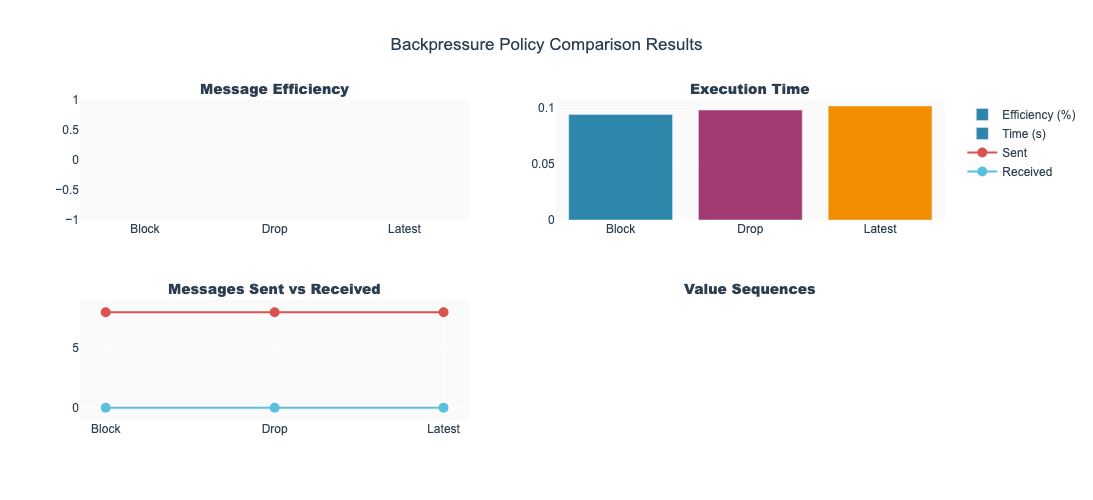


📊 Policy Comparison Summary:
   Block: 0.0% efficiency, 0.09s execution time
   Drop: 0.0% efficiency, 0.10s execution time
   Latest: 0.0% efficiency, 0.10s execution time


In [11]:
class BackpressureExperiment:
    """Dedicated experiment for understanding backpressure policies."""
    
    def __init__(self):
        self.results = {}
        self.visualizer = GraphVisualizer()
    
    def run_policy_comparison(self, producer_delay=0, consumer_delay=100, capacity=3, message_count=10):
        """Run the same configuration with different policies and compare results."""
        
        policies = {
            'Block': Block(),
            'Drop': Drop(), 
            'Latest': Latest()
        }
        
        results = {}
        
        for policy_name, policy in policies.items():
            print(f"\n🔍 Testing {policy_name} policy...")
            
            # Create fresh nodes
            producer = EnhancedProducer(f"producer_{policy_name.lower()}", message_count, producer_delay)
            consumer = EnhancedConsumer(f"consumer_{policy_name.lower()}", consumer_delay)
            
            # Create graph
            graph = Subgraph.from_nodes(f"test_{policy_name.lower()}", [producer, consumer])
            graph.connect(
                (producer.name, "output"), 
                (consumer.name, "input"), 
                capacity=capacity,
                policy=policy
            )
            
            # Run simulation
            start_time = time.time()
            scheduler = Scheduler(SchedulerConfig(shutdown_timeout_s=2.0))
            scheduler.register(graph)
            
            # Simple execution loop for controlled testing
            tick_count = 0
            max_ticks = message_count * 3  # Allow extra ticks for completion
            
            while tick_count < max_ticks and not producer.get_stats().is_complete:
                producer._handle_tick()
                tick_count += 1
                time.sleep(0.01)  # Small delay to simulate real execution
            
            end_time = time.time()
            
            # Collect results
            producer_stats = producer.get_stats()
            consumer_stats = consumer.get_stats()
            
            results[policy_name] = {
                'policy': policy_name,
                'messages_sent': producer_stats.messages_sent,
                'messages_received': consumer_stats.messages_received,
                'efficiency': (consumer_stats.messages_received / producer_stats.messages_sent) * 100 if producer_stats.messages_sent > 0 else 0,
                'execution_time': end_time - start_time,
                'received_values': consumer_stats.all_values.copy()
            }
            
            print(f"   Sent: {producer_stats.messages_sent}, Received: {consumer_stats.messages_received}")
            print(f"   Efficiency: {results[policy_name]['efficiency']:.1f}%")
            print(f"   Values: {consumer_stats.all_values}")
        
        return results
    
    def visualize_policy_comparison(self, results):
        """Create visualization comparing policy results."""
        
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Message Efficiency', 'Execution Time', 'Messages Sent vs Received', 'Value Sequences'),
            specs=[[{"type": "bar"}, {"type": "bar"}],
                   [{"type": "scatter"}, {"type": "scatter"}]]
        )
        
        policies = list(results.keys())
        # Use local palette to avoid referencing non-existent self.colors
        palette = {
            "primary": "#2E86AB",
            "accent1": "#A23B72",
            "accent2": "#F18F01",
            "sent": "#D9534F",
            "received": "#5BC0DE",
            "text": "#2C3E50",
        }
        series_colors = [palette["primary"], palette["accent1"], palette["accent2"]]
        
        # Efficiency comparison
        efficiencies = [results[p]['efficiency'] for p in policies]
        fig.add_trace(
            go.Bar(x=policies, y=efficiencies, name='Efficiency (%)', 
                   marker_color=series_colors[:len(policies)]),
            row=1, col=1
        )
        
        # Execution time comparison
        exec_times = [results[p]['execution_time'] for p in policies]
        fig.add_trace(
            go.Bar(x=policies, y=exec_times, name='Time (s)', 
                   marker_color=series_colors[:len(policies)]),
            row=1, col=2
        )
        
        # Sent vs Received
        sent = [results[p]['messages_sent'] for p in policies]
        received = [results[p]['messages_received'] for p in policies]
        
        fig.add_trace(
            go.Scatter(x=policies, y=sent, mode='markers+lines', name='Sent',
                       marker=dict(size=10, color=palette["sent"])),
            row=2, col=1
        )
        fig.add_trace(
            go.Scatter(x=policies, y=received, mode='markers+lines', name='Received',
                       marker=dict(size=10, color=palette["received"])),
            row=2, col=1
        )
        
        # Value sequences
        for i, policy in enumerate(policies):
            values = results[policy]['received_values']
            if values:
                fig.add_trace(
                    go.Scatter(x=list(range(len(values))), y=values, 
                               mode='lines+markers', name=f'{policy} Values',
                               line=dict(color=series_colors[i % len(series_colors)])),
                    row=2, col=2
                )
        
        fig.update_layout(
            height=500,  # Fixed for dashboard panel
            title_text="Backpressure Policy Comparison Results",
            title_x=0.5,
            showlegend=True,
            font=dict(family='Arial, sans-serif', size=12, color=palette["text"]),
            plot_bgcolor='#fafafa',
            paper_bgcolor='white',
        )
        
        # Guarded annotation font styling
        if "annotations" in fig.layout and fig.layout.annotations:
            for ann in fig.layout.annotations:
                ann.font = dict(size=14, color=palette["text"], family='Arial Black')
        
        return fig

# Create backpressure experiment
bp_experiment = BackpressureExperiment()

# Run comparison with backpressure conditions
print("🧪 Ready for backpressure policy comparison")
print("Configuration suggestion: Fast producer (0ms), Slow consumer (100ms), Small capacity (3)")

comparison_results = bp_experiment.run_policy_comparison(
    producer_delay=0,
    consumer_delay=100, 
    capacity=3,
    message_count=8
)

fig = bp_experiment.visualize_policy_comparison(comparison_results)
fig.show()

print("\n📊 Policy Comparison Summary:")
for policy, result in comparison_results.items():
    print(f"   {policy}: {result['efficiency']:.1f}% efficiency, {result['execution_time']:.2f}s execution time")

## Step 6: Advanced Monitoring and Observability
Optional, collapsible. Demonstrates structured logging, metrics, tracing.

In [8]:
class ObservabilityDemo:
    """Demonstration of Meridian's observability features."""
    
    def __init__(self):
        self.setup_observability()
    
    def setup_observability(self):
        """Configure comprehensive observability."""
        
        # Configure with development settings for detailed visibility
        configure_observability(ObservabilityConfig(
            log_level="DEBUG",
            log_json=False,  # Human-readable for notebooks
            metrics_enabled=True,
            metrics_namespace="meridian_tutorial",
            tracing_enabled=True,
            tracing_provider="inmemory",
            tracing_sample_rate=1.0  # 100% sampling for demo
        ))
        
        print("✅ Observability configured with full monitoring")
    
    def create_monitored_node(self, name: str, node_type: str = "processor") -> Node:
        """Create a node with comprehensive monitoring."""
        
        class MonitoredNode(Node):
            def __init__(self, name: str):
                if node_type == "producer":
                    super().__init__(
                        name=name,
                        inputs=[],
                        outputs=[Port("output", PortDirection.OUTPUT, spec=PortSpec("output", dict))]
                    )
                elif node_type == "consumer":
                    super().__init__(
                        name=name,
                        inputs=[Port("input", PortDirection.INPUT, spec=PortSpec("input", dict))],
                        outputs=[]
                    )
                else:  # processor
                    super().__init__(
                        name=name,
                        inputs=[Port("input", PortDirection.INPUT, spec=PortSpec("input", dict))],
                        outputs=[Port("output", PortDirection.OUTPUT, spec=PortSpec("output", dict))]
                    )
                
                self.message_count = 0
                self.processing_times = []
            
            def on_start(self):
                """Enhanced startup with logging."""
                super().on_start()
                logger = get_logger()
                with with_context(node=self.name):
                    logger.info("node.enhanced_start", f"Enhanced node {self.name} starting with monitoring")
            
            def _handle_message(self, port: str, msg: Message):
                """Enhanced message handling with detailed monitoring."""
                logger = get_logger()
                start_time = time.perf_counter()
                
                with with_context(node=self.name, port=port, trace_id=msg.get_trace_id()):
                    logger.debug("node.message_start", f"Processing message {self.message_count + 1}")
                    
                    # Simulate processing
                    time.sleep(0.01)  # 10ms processing time
                    
                    # Transform the message
                    if hasattr(msg.payload, 'get'):
                        processed_payload = {
                            **msg.payload,
                            'processed_by': self.name,
                            'processing_time': time.perf_counter() - start_time,
                            'sequence': self.message_count
                        }
                    else:
                        processed_payload = {
                            'original_value': msg.payload,
                            'processed_by': self.name,
                            'processing_time': time.perf_counter() - start_time,
                            'sequence': self.message_count
                        }
                    
                    self.message_count += 1
                    processing_time = time.perf_counter() - start_time
                    self.processing_times.append(processing_time)
                    
                    # Emit if this is a processor
                    if self.outputs:
                        output_msg = Message(MessageType.DATA, processed_payload)
                        self.emit("output", output_msg)
                        logger.debug("node.message_emitted", f"Emitted processed message")
                    
                    logger.info("node.message_complete", 
                               f"Message processed successfully",
                               processing_time=processing_time,
                               message_sequence=self.message_count)
            
            def _handle_tick(self):
                """Enhanced tick handling for producers."""
                if not self.outputs:  # Only producers should tick
                    return
                    
                logger = get_logger()
                with with_context(node=self.name):
                    if self.message_count < 5:  # Generate 5 messages
                        payload = {
                            'id': str(uuid.uuid4()),
                            'value': self.message_count,
                            'timestamp': time.time(),
                            'source': self.name
                        }
                        
                        msg = Message(MessageType.DATA, payload)
                        self.emit("output", msg)
                        
                        logger.info("node.tick_emit", f"Generated message {self.message_count + 1}")
            
            def on_stop(self):
                """Enhanced shutdown with statistics."""
                super().on_stop()
                logger = get_logger()
                with with_context(node=self.name):
                    avg_time = sum(self.processing_times) / len(self.processing_times) if self.processing_times else 0
                    logger.info("node.enhanced_stop", 
                               f"Node {self.name} stopping",
                               total_messages=self.message_count,
                               avg_processing_time=avg_time)
        
        return MonitoredNode(name)
    
    def run_observability_demo(self):
        """Run a complete observability demonstration."""
        
        print("🔍 Starting comprehensive observability demo...")
        
        # Create monitored nodes
        producer = self.create_monitored_node("obs_producer", "producer")
        processor = self.create_monitored_node("obs_processor", "processor") 
        consumer = self.create_monitored_node("obs_consumer", "consumer")
        
        # Create graph
        graph = Subgraph.from_nodes("observability_demo", [producer, processor, consumer])
        
        # Connect with different capacities to show backpressure
        graph.connect(("obs_producer", "output"), ("obs_processor", "input"), capacity=2)
        graph.connect(("obs_processor", "output"), ("obs_consumer", "input"), capacity=3)
        
        # Create scheduler with detailed configuration
        scheduler_config = SchedulerConfig(
            tick_interval_ms=100,
            fairness_ratio=(4, 2, 1),
            max_batch_per_node=2,
            idle_sleep_ms=5,
            shutdown_timeout_s=3.0
        )
        
        scheduler = Scheduler(scheduler_config)
        scheduler.register(graph)
        
        print("📊 Graph created with comprehensive monitoring")
        print("🚀 Starting execution with detailed logging...")
        
        # Run the scheduler
        try:
            scheduler.run()
            print("✅ Observability demo completed successfully!")
        except Exception as e:
            print(f"❌ Demo error: {e}")
        
        # Display final statistics
        print(f"\n📈 Final Statistics:")
        print(f"   Producer messages: {producer.message_count}")
        print(f"   Processor messages: {processor.message_count}")
        print(f"   Consumer messages: {consumer.message_count}")
        
        if processor.processing_times:
            avg_time = sum(processor.processing_times) / len(processor.processing_times)
            print(f"   Average processing time: {avg_time*1000:.2f}ms")

# Run observability demonstration
obs_demo = ObservabilityDemo()
print("🧭 Observability demo ready")
obs_demo.run_observability_demo()

✅ Observability configured with full monitoring
🧭 Observability demo ready
🔍 Starting comprehensive observability demo...
📊 Graph created with comprehensive monitoring
🚀 Starting execution with detailed logging...


{"ts":1754534526.3751,"level":"DEBUG","event":"scheduler.register_subgraph","message":"Registered subgraph observability_demo","json":false}
{"ts":1754534526.375128,"level":"INFO","event":"scheduler.start","message":"Scheduler starting","json":false,"graphs_count":1,"tick_interval_ms":100}
{"ts":1754534526.375165,"level":"INFO","event":"node.start","message":"Node obs_producer starting","node":"obs_producer","json":false}
{"ts":1754534526.375176,"level":"INFO","event":"node.enhanced_start","message":"Enhanced node obs_producer starting with monitoring","node":"obs_producer","json":false}
{"ts":1754534526.375187,"level":"INFO","event":"node.start","message":"Node obs_processor starting","node":"obs_processor","json":false}
{"ts":1754534526.3751948,"level":"INFO","event":"node.enhanced_start","message":"Enhanced node obs_processor starting with monitoring","node":"obs_processor","json":false}
{"ts":1754534526.375202,"level":"INFO","event":"node.start","message":"Node obs_consumer startin

✅ Observability demo completed successfully!

📈 Final Statistics:
   Producer messages: 0
   Processor messages: 29
   Consumer messages: 33
   Average processing time: 11.91ms


{"ts":1754534529.266004,"level":"DEBUG","event":"node.emit","message":"Emitting DATA message","trace_id":"666d97f2-a8ea-40f3-9967-2b0f40be5c9b","node":"obs_processor","port":"output","json":false,"message_type":"DATA"}
{"ts":1754534529.266861,"level":"DEBUG","event":"edge.enqueue","message":"Item enqueued, depth=1","trace_id":"b50367e2-6ee9-4358-bbae-57fd4660473b","node":"obs_processor","edge_id":"obs_processor:output->obs_consumer:input","port":"input","json":false}
{"ts":1754534529.267165,"level":"DEBUG","event":"scheduler.message_routed","message":"Message routed successfully: OK","trace_id":"b50367e2-6ee9-4358-bbae-57fd4660473b","node":"obs_processor","edge_id":"obs_processor:output->obs_consumer:input","port":"output","json":false}
{"ts":1754534529.2673228,"level":"DEBUG","event":"node.message_emitted","message":"Emitted processed message","trace_id":"b50367e2-6ee9-4358-bbae-57fd4660473b","node":"obs_processor","port":"input","json":false}
{"ts":1754534529.267384,"level":"INFO","e

### Step 3: Interactive Graph Configuration
Sliders and actions to build/run a simple producer→consumer graph with a configurable edge policy.
The UI is arranged as:
- Row 1: Graph Config (48% x 500px) | Graph Topology (48% x 500px)
- Row 2: Performance Dashboard (100% x 500px)
- Row 3: Execution Log (100% x 150px)

## Summary and Next Steps
You now have an interactive, professional layout and optional deeper experiments.
For production guidance, see:
- ../../docs/getting-started/quickstart.md
- ../../docs/concepts/observability.md
- ../../docs/guides/performance.md

In [9]:
# Environment verification and imports (stable height via cell metadata)
import sys
import platform
import time
import threading
from typing import Any, Dict, List, Tuple, Optional
from dataclasses import dataclass
from collections import deque
import uuid

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import networkx as nx
import pandas as pd
import numpy as np

# Reproducibility
np.random.seed(42)

# Configure matplotlib for better appearance
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = '#f8f9fa'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

print("🔧 Environment Information:")
print(f"   Python: {sys.version.split()[0]}")
print(f"   Platform: {platform.platform()}")

# Lightweight sanity check
assert hasattr(widgets, "VBox"), "ipywidgets not available"

# Verify all required packages
try:
    import meridian
    import ipywidgets
    import matplotlib
    import networkx
    import pandas
    import plotly
    
    print("\n📦 Package Versions:")
    print(f"   Meridian: {getattr(meridian, '__version__', 'dev')}")
    print(f"   ipywidgets: {ipywidgets.__version__}")
    print(f"   matplotlib: {matplotlib.__version__}")
    print(f"   networkx: {networkx.__version__}")
    print(f"   pandas: {pandas.__version__}")
    print(f"   plotly: {plotly.__version__}")
    print("\n✅ Environment verification complete!")
except ImportError as e:
    print(f"❌ Missing dependency: {e}")
    print("Please run the setup commands above.")

🔧 Environment Information:
   Python: 3.12.11
   Platform: macOS-15.6-arm64-arm-64bit

📦 Package Versions:
   Meridian: 0.0.0
   ipywidgets: 8.1.7
   matplotlib: 3.10.5
   networkx: 3.5
   pandas: 2.3.1
   plotly: 6.2.0

✅ Environment verification complete!


In [10]:
# Import Meridian Runtime components
from meridian.core import (
    Node, Message, MessageType, Subgraph, Scheduler, SchedulerConfig,
    PortSpec, Port, PortDirection
)
from meridian.observability.config import ObservabilityConfig, configure_observability
from meridian.observability.logging import get_logger, with_context
from meridian.core.policies import Block, Drop, Latest, Coalesce, PutResult

# Verify API compatibility
assert hasattr(Subgraph, "from_nodes"), "Unexpected Subgraph API; update notebook to match library"
assert hasattr(Scheduler, "register"), "Unexpected Scheduler API; update notebook to match library"

print("✅ Meridian Runtime imported successfully!")
print("📚 Ready to explore dataflow graphs!")

✅ Meridian Runtime imported successfully!
📚 Ready to explore dataflow graphs!
